In [1]:
from sklearn.decomposition import IncrementalPCA, NMF, TruncatedSVD
%run './Loading Dataset and Preprocess.ipynb'
import pickle
RUN_DEMONSTRATION = False

# Some tools for later

## Datasets and Dataloaders

In [2]:
batch_size = 4000
nworkers = 1
def dl_factory(dataset):
    return torch.utils.data.DataLoader(
        dataset, batch_size=batch_size,
        worker_init_fn=h5worker_init_fn,
        num_workers=nworkers,
    )


# dataset objects that do not initialize in the main thread
tiles_dataset_bw_train = H5TilesDataset(
    test=False, color=False, init_files=False,
    root='./dataset/hdf5/160x160/')
tiles_dataset_c_train = H5TilesDataset(
    test=False, init_files=False,
    root='./dataset/hdf5/160x160x3/')
tiles_dataset_bw_test = H5TilesDataset(
    test=True, color=False, init_files=False,
    root='./dataset/hdf5/160x160/')
tiles_dataset_c_test = H5TilesDataset(
    test=True, init_files=False,
    root='./dataset/hdf5/160x160x3/')

batched_tiles_dataset_bw_train = dl_factory(
    tiles_dataset_bw_train)
batched_tiles_dataset_c_train = dl_factory(
    tiles_dataset_c_train)
batched_tiles_dataset_bw_test = dl_factory(
    tiles_dataset_bw_test)
batched_tiles_dataset_c_test = dl_factory(
    tiles_dataset_c_test)


# these ones initialize in the main thread
tiles_dataset_bw_train = H5TilesDataset(
    test=False, color=False,
    root='./dataset/hdf5/160x160/')
tiles_dataset_c_train = H5TilesDataset(
    test=False,
    root='./dataset/hdf5/160x160x3/')
tiles_dataset_bw_test = H5TilesDataset(
    test=True, color=False,
    root='./dataset/hdf5/160x160/')
tiles_dataset_c_test = H5TilesDataset(
    test=True,
    root='./dataset/hdf5/160x160x3/')

## Model Fitters

In [3]:
# function to incrementally fit a model with a batched dataset
def incremental_fit_model(model, batches, filename, retrain=False):
    
    if not filename.startswith('models/'):
        filename = f'models/{filename}'
    
    # check if already exists (assertion error halts)
    if not retrain:
        try:
            save_model('', filename)
        except AssertionError:
            print('Model has already been trained. Returned cached version')
            return load_model(filename)
        
    lds = len(batches)
    with Timer() as t:
        t.lap()
        
        for i, (X, Y) in enumerate(batches):
            model.partial_fit(X.view(X.shape[0], -1))
            lap = t.lap()
            laptime = lap - t.laps[-2]
            print(f'{i} / {lds} : time taken {lap:.0f}s batch took'
                  f' {laptime:.0f}s remaining '
                  f'{int((lds - i) * lap / (i + 1)) // 60}m',
                  '    ',
                  end='\r')
        print(t)
    save_model(model, filename, overwrite=True)
    return model
    
def save_model(model, filename, overwrite=False):
    if not overwrite:
        assert not Path(filename).exists(), 'Model file exists! to overwrite, set overwrite=True'
    Path(filename).parent.mkdir(exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
        
def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def get_sample(ds, size):
    return tuple(zip(*op.itemgetter(*np.random.choice(len(ds), size=size, replace=False))(ds)))

# PCA

In [4]:
# initialize PCA model
pca_bw = IncrementalPCA()

# fit PCA model
pca_trained = incremental_fit_model(pca_bw, batched_tiles_dataset_bw_train, 'models/PCA_160x160.pkl')

Model has already been trained. Returned cached version


## Show explained variance

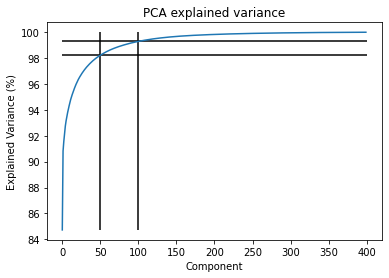

In [5]:
if RUN_DEMONSTRATION:
    cum_var = np.cumsum(pca_trained.explained_variance_ /
                        pca_trained.explained_variance_.sum() * 100)
    plt.plot(cum_var)
    plt.vlines([100, 50], cum_var[0], cum_var[-1])
    plt.hlines(cum_var[[50, 100]], 0, 400)
    plt.ylabel('Explained Variance (%)')
    plt.xlabel('Component')
    plt.title('PCA explained variance')
    plt.show()

The explained variance shows clearly that 50 components explains about 98% of variation, and 100 components explains about 99%.

## Results

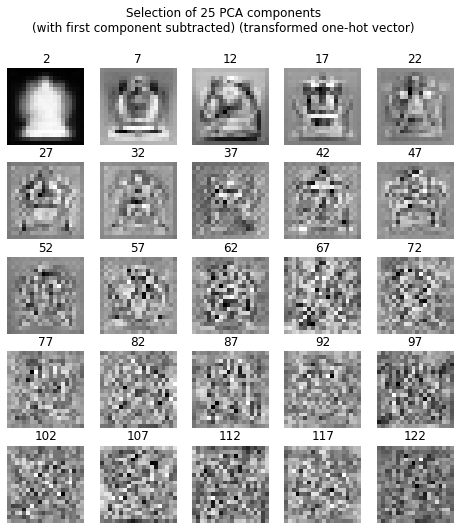

In [6]:
if RUN_DEMONSTRATION:
    components = pca_trained.inverse_transform(np.eye(400)).reshape(400, 20, 20)
    plt.figure(figsize=(8, 8.4))
    plt.suptitle('Selection of 25 PCA components\n(with first component subtracted) (transformed one-hot vector)')
    for i in range(25):
        plt.subplot(5, 5, i+1)
        comp = i * 5 + 1
        plt.title(f'{comp + 1}')
        plt.imshow(components[comp] - components[0], cmap='Greys_r')
        plt.axis('off')
    plt.show()

Here, we can see the features that are being captured by the PCA. By about component 62, it appears to be describing noise. This supports the previous hypothesis that the best number of components is between 50 and 100.

<ipython-input-7-ecb7c811f584>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(nims, cols, i+1)
<ipython-input-7-ecb7c811f584>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(nims, cols, cols)


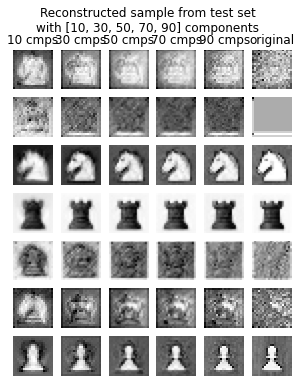

In [7]:
# load examples from the train set
def plot_examples(ncomponents, nims, decomp):
    ims = get_sample(tiles_dataset_bw_test, nims)[0]
    trans = decomp.transform(np.array(ims).reshape(nims, -1))
    # ignore the PCs above 60
    outims = []
    cols = len(ncomponents) + 1
    for n in ncomponents:
        t2 = trans.copy()
        t2[:, n:] = 0
        outims.append(decomp.inverse_transform(t2))
        
    plt.suptitle(f'Reconstructed sample from test set\nwith {ncomponents} components')
    for i, ims in enumerate(zip(*outims, ims)):
        for j, im in enumerate(ims):
            plt.subplot(nims, cols, i*cols + j + 1)
            plt.imshow(im.reshape(20, 20), cmap='Greys_r')
            plt.axis('off')
    for i, comps in enumerate(ncomponents):
        plt.subplot(nims, cols, i+1)
        plt.title(f'{comps} cmps')
    plt.subplot(nims, cols, cols)
    plt.title(f'original')
    plt.show()
if RUN_DEMONSTRATION:
    plt.figure(figsize=(5, 6))
    plot_examples([10, 30, 50, 70, 90], 7, pca_trained)

## try removing PCs from a few examples to see how it affects the image

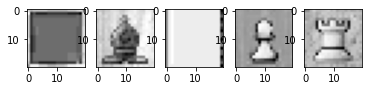

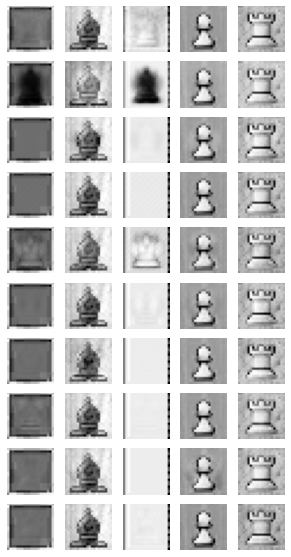

In [8]:
if RUN_DEMONSTRATION:
    nims = 5
    np.random.seed(7)
    ims = np.array(get_sample(tiles_dataset_bw_test, nims)[0])
    for i in range(nims):
        plt.subplot(1, nims, i+1)
        plt.imshow(ims[i], cmap='Greys_r')
    plt.show()

    plt.figure(figsize=(5, 10))
    trans = pca_trained.transform(ims.reshape(nims, -1))
    comps_to_remove = list(range(10))
    for i , cmp in enumerate(comps_to_remove):
        t = trans.copy()
        t[:, cmp] = 0
        # images to show
        sims = pca_trained.inverse_transform(t)
        for j, im in enumerate(sims.reshape(nims, 20, 20)):
            plt.subplot(
                len(comps_to_remove),
                nims,
                i * nims + j + 1)
            plt.imshow(im, cmap='Greys_r')
            plt.axis('off')
    plt.show()

    ims, labs = get_sample(tiles_dataset_bw_test, 10000)
    trans = pca_trained.transform(np.array(ims).reshape(-1, 400))
    labs = np.array(labs)

# NMF (on sample)

In [9]:
from sklearn.decomposition import MiniBatchDictionaryLearning

nmf = MiniBatchDictionaryLearning(
    n_components=70, fit_algorithm='cd',
    positive_dict=True)

nmf = incremental_fit_model(nmf, batched_tiles_dataset_bw_train, 'models/NMF_160x160.pkl')

Model has already been trained. Returned cached version


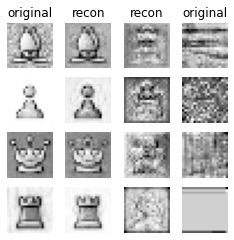

In [10]:
if RUN_DEMONSTRATION:
    # load a sample
    np.random.seed(5000000)
    ims, labs = map(np.array, get_sample(tiles_dataset_bw_test, 100))

    reps = nmf.transform(np.reshape(ims, (-1, 400)))
    recon = reps @ nmf.components_

    plt.figure(figsize=(4, 20))
    i = 0
    for _ in range(10):
        while labs[i] != 12:
            i += 1

        plt.subplot(20, 4, _*4 + 3)
        plt.imshow(recon.reshape(-1, 20, 20)[i], cmap='Greys_r')
        plt.axis('off')
        if _ < 1:
            plt.title('recon')
        plt.subplot(20, 4, _*4 + 4)
        plt.imshow(ims[i], cmap='Greys_r')
        plt.axis('off')

        if _ < 1:
            plt.title('original')
        while labs[i] == 12:
            i += 1
        plt.subplot(20, 4, _*4 + 2)
        if _ < 1:
            plt.title('recon')
        plt.imshow(recon.reshape(-1, 20, 20)[i], cmap='Greys_r')
        plt.axis('off')
        plt.subplot(20, 4, _*4 + 1)
        if _ < 1:
            plt.title('original')
        plt.imshow(ims[i], cmap='Greys_r')
        plt.axis('off')
        i += 1
        if i == 20:
            break
    plt.show()

# Feature Extraction (background removal)

Attempt to remove the tiles backgrounds by subtracting common features from images/vectors over an individual chessboard.

In [11]:
from sklearn.feature_selection import VarianceThreshold
from itertools import chain, islice


orig_idx = np.arange(64).reshape(8, 8)
_white_idx = np.array(
    list(zip(orig_idx[::2, ::2], orig_idx[1::2, 1::2]))
).reshape(32)
_black_idx = np.array(list(zip(orig_idx[::2, 1::2], orig_idx[1::2, ::2]))).reshape(32)

_rev_wb_idx = np.argsort(np.reshape((_white_idx, _black_idx), (64)))


_white_idx_getter = op.itemgetter(*_white_idx)
_black_idx_getter = op.itemgetter(*_black_idx)
_rev_wb_idx_getter = op.itemgetter(*_rev_wb_idx)

In [12]:
def split_white_black(pieces):
    assert len(pieces) == 64, 'must have whole chess board'
    return _white_idx_getter(pieces), _black_idx_getter(pieces)

def join_white_black(white, black):
    return _rev_wb_idx_getter(np.array((white, black)).reshape(64, -1))


def remove_background(transformed, thresh=1, lower=True):
    
    # seperate white and black tiles
    white, black = map(np.array, split_white_black(transformed))
    return join_white_black(
        white - np.median(white, axis=0),
        black - np.median(black, axis=0)
    )
    white_var = np.ptp(white, axis=0)[:]
    black_var = np.ptp(black, axis=0)[:]
    
    out = [None, None]
    transformed = np.array(transformed)
    where = np.ones(transformed.shape[1], dtype=bool)
    for i, (var, tiles) in enumerate(zip(
        [white_var, black_var], [white, black])):
        # rescale var to have maximum value of 1
        # (minimum is 0 if all tiles have that component equal)
        var = var / var.max()
        
        if lower:
            where = where & (var < thresh)
        else:
            where = where & (var > thresh)
    transformed[:, where] = 0
    print(f'removed {np.sum(where)} variables')
    return transformed
    

removed 180 variables
removed 386 variables
removed 29 variables
removed 15 variables
removed 2 variables
removed 1 variables


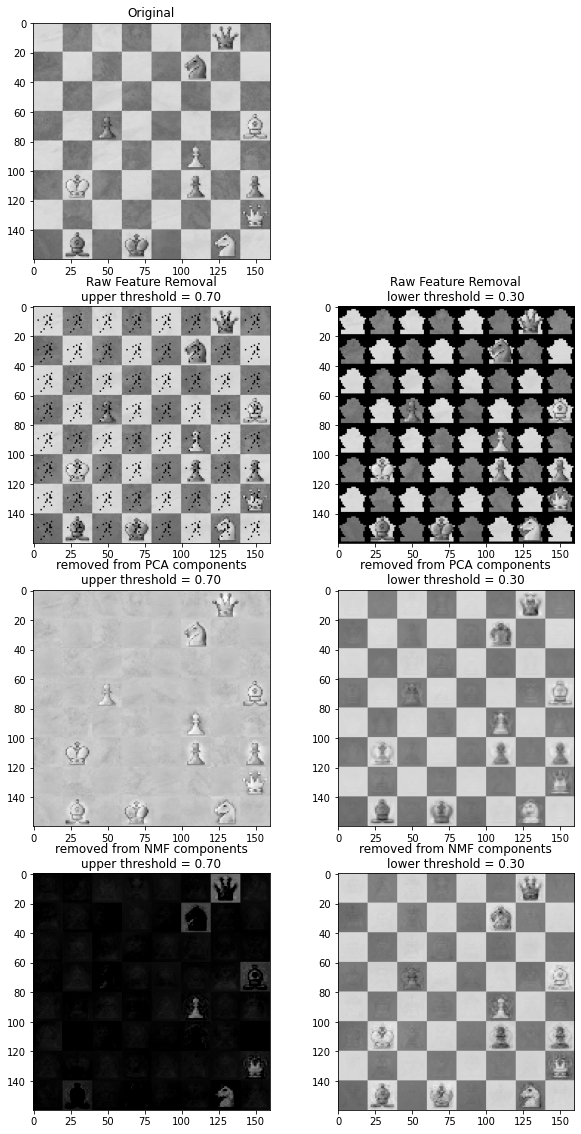

removed 219 variables
removed 380 variables
removed 68 variables
removed 55 variables
removed 2 variables
removed 1 variables


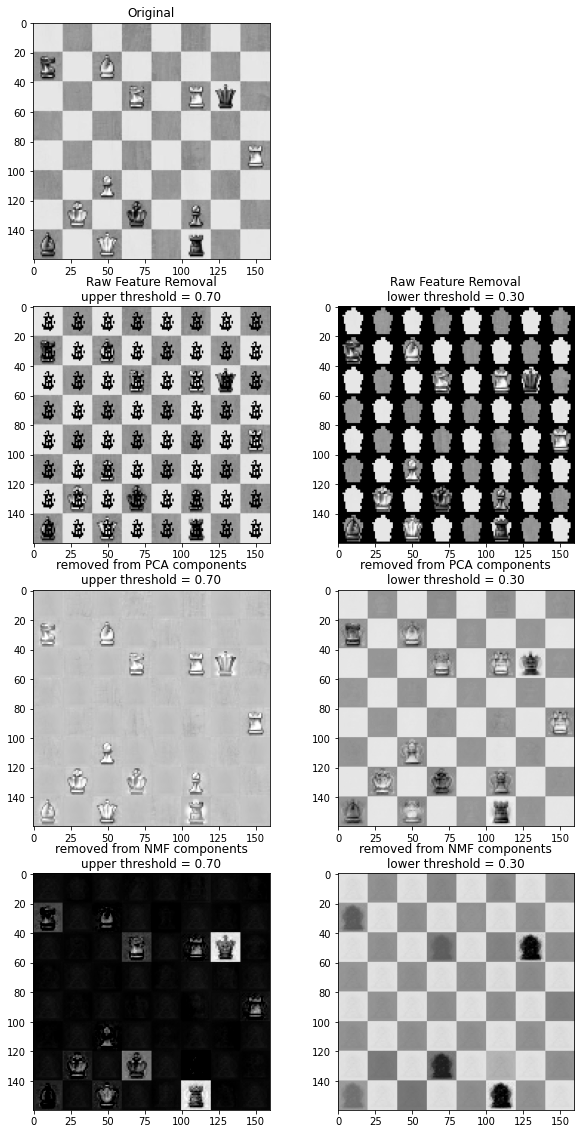

removed 220 variables
removed 361 variables
removed 63 variables
removed 25 variables
removed 2 variables
removed 1 variables


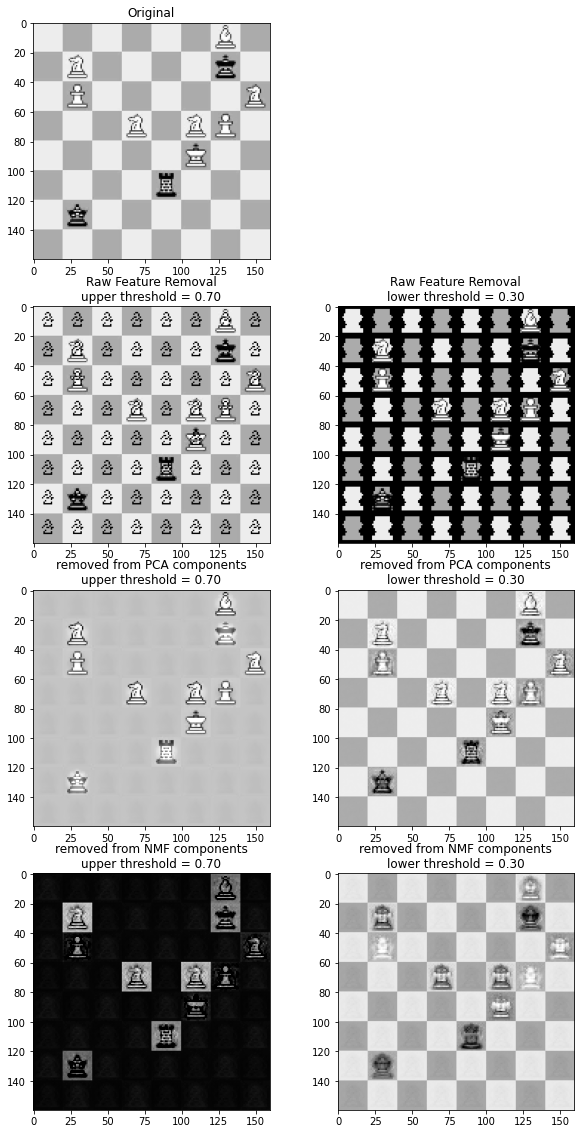

removed 218 variables
removed 384 variables
removed 58 variables
removed 6 variables
removed 2 variables
removed 1 variables


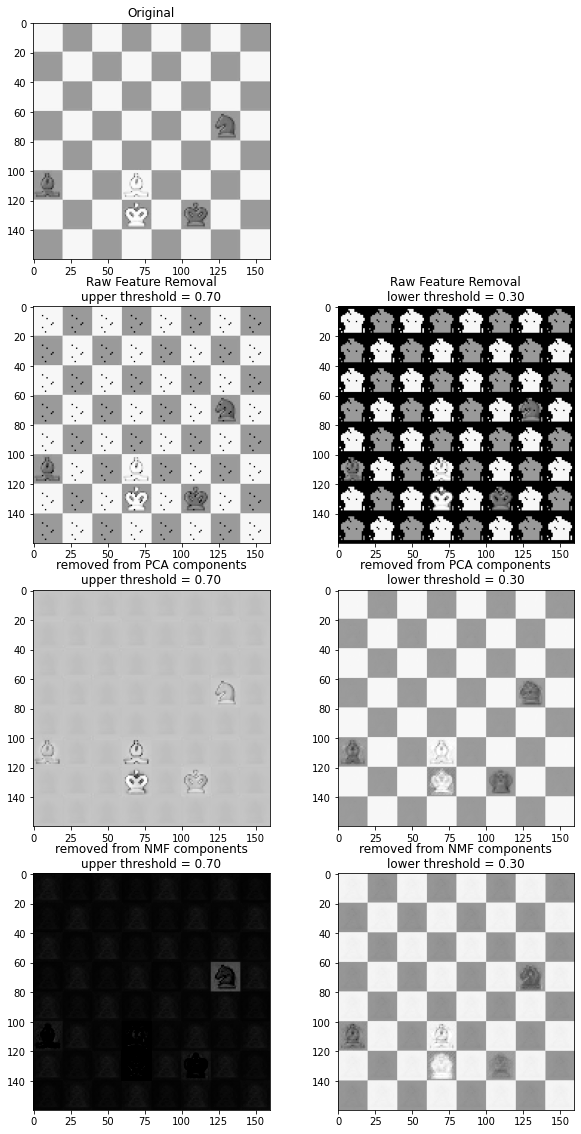

removed 201 variables
removed 379 variables
removed 68 variables
removed 95 variables
removed 2 variables
removed 1 variables


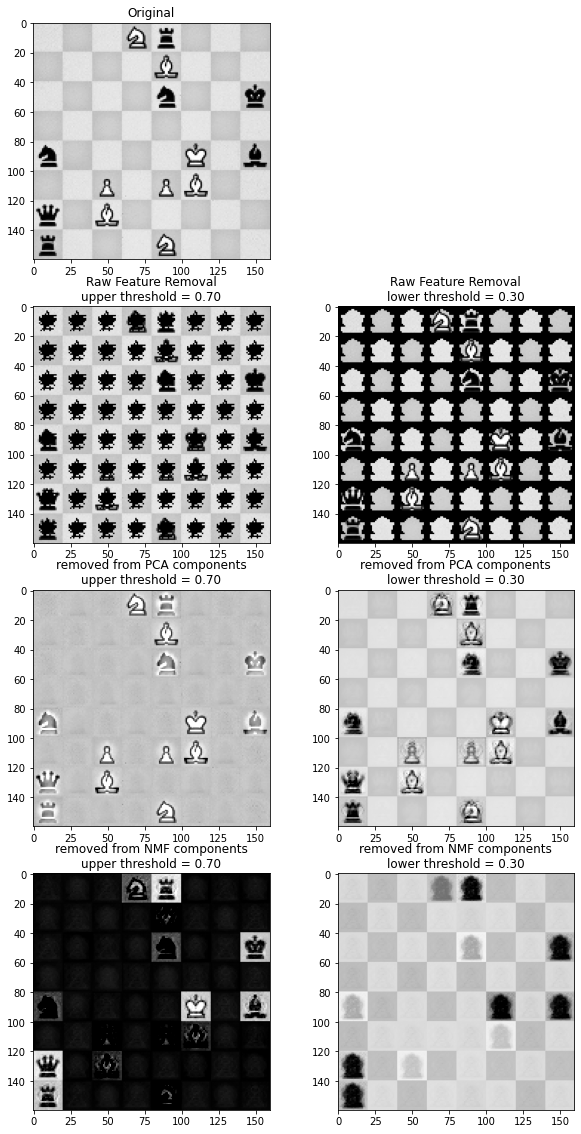

removed 215 variables
removed 387 variables
removed 65 variables
removed 55 variables
removed 2 variables
removed 1 variables


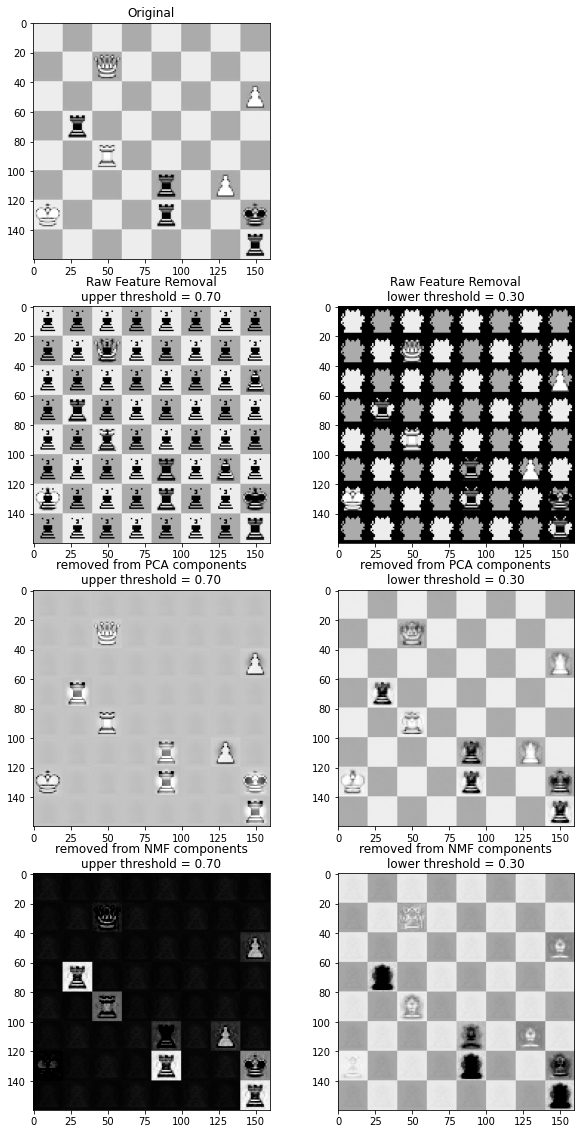

removed 216 variables
removed 394 variables
removed 54 variables
removed 29 variables
removed 2 variables
removed 0 variables


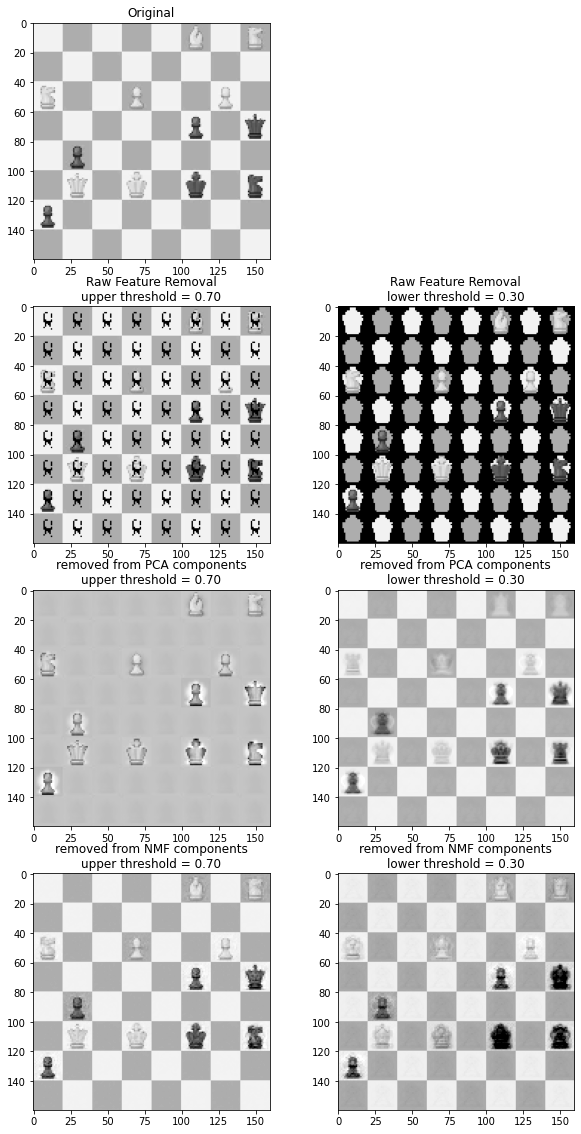

removed 206 variables
removed 395 variables
removed 68 variables
removed 85 variables
removed 2 variables
removed 1 variables


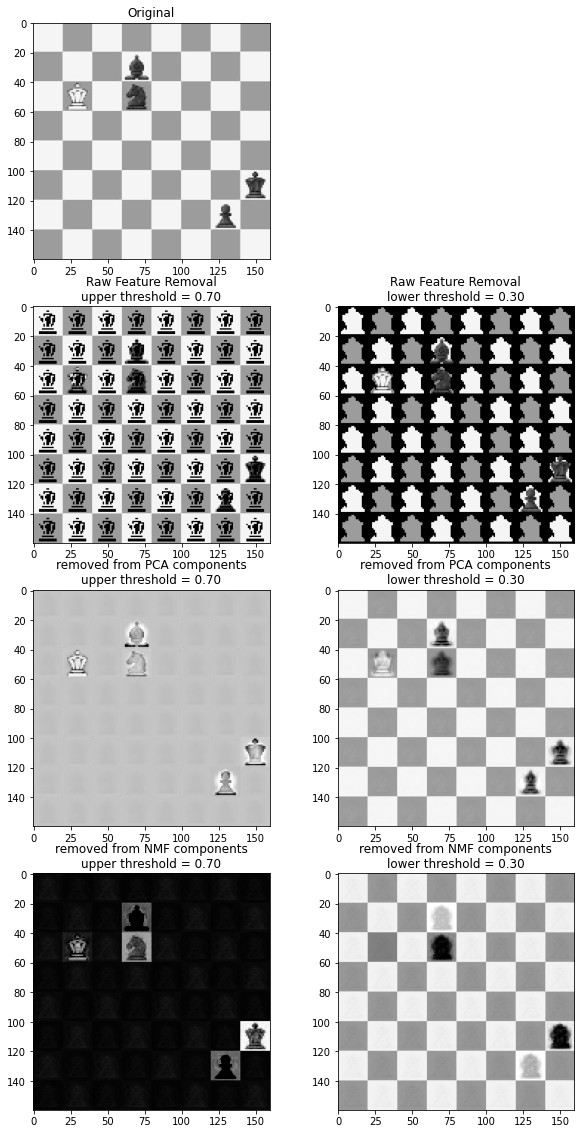

removed 157 variables
removed 384 variables
removed 56 variables
removed 13 variables
removed 1 variables
removed 1 variables


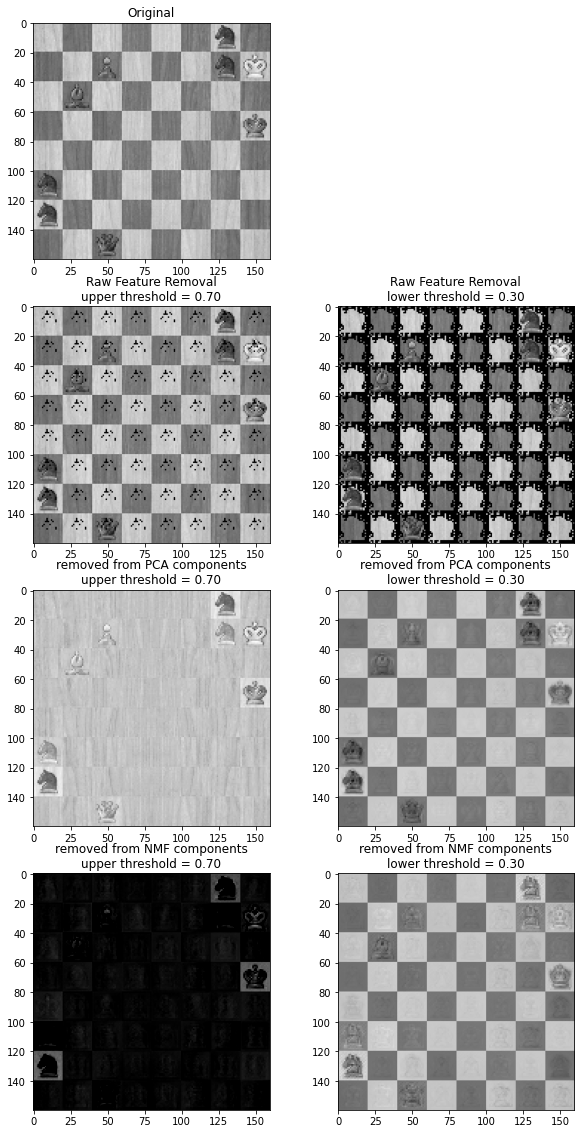

removed 223 variables
removed 394 variables
removed 67 variables
removed 75 variables
removed 2 variables
removed 1 variables


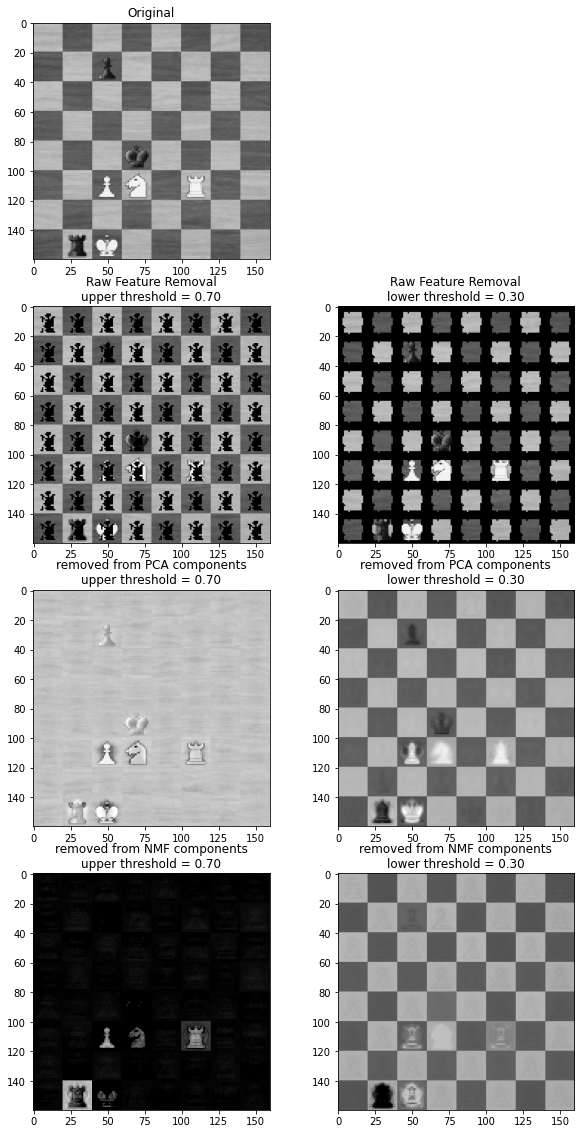

In [13]:
if RUN_DEMONSTRATION:
    for cbn in np.random.choice(20000, size=10, replace=False):
        cb_vecs = []
        for i in range(cbn*64, cbn*64+64):
            cb_vecs.append(tiles_dataset_bw_test[i][0].flatten())

        def plot_chessboard(tiles):
            # assume no color
            tiles = np.array(tiles)
            imshape = tiles.shape[1:]
            tiles = tiles.reshape(8, 8, 20, 20)
            tiles = tiles.transpose(0, 2, 1, 3)
            tiles = tiles.reshape(160, 160)
            plt.imshow(tiles, cmap='Greys_r', vmin=0, vmax=255)

        def plot_model_removed(tiles, toptitle, trans=None, inv_trans=None, thresh=None, lower=True):
            
            title = toptitle
            if trans is not None:
                title += f'\n{"lower" if lower else "upper"} threshold = {thresh:.2f}'
                todraw = remove_background(trans(tiles), thresh, lower)
                todraw = inv_trans(todraw)
            else:
                todraw = tiles
                
            plt.title(title)
            plot_chessboard(todraw)

        plt.figure(figsize=(10, 20))
        plt.subplot(4, 2, 1)
        plot_model_removed(cb_vecs, 'Original')
        
        thresh = 0.3  # what proportion of the maximum variation does this feature exhibit before it is removed
        # 0 - remove no features, 1 - remove almost all features
        for lower in [1, 0]:
            plt.subplot(4, 2, 3 + lower)
            plot_model_removed(
                cb_vecs, 'Raw Feature Removal',
                lambda x: x, lambda x: x,
                thresh=thresh if lower else 1-thresh, lower=lower
            )

            plt.subplot(4, 2, 5 + lower)
            plot_model_removed(
                cb_vecs, 'removed from PCA components',
                pca_trained.transform, pca_trained.inverse_transform,
                thresh=thresh if lower else 1-thresh, lower=lower
            )

            plt.subplot(4, 2, 7 + lower)
            plot_model_removed(
                cb_vecs, 'removed from NMF components',
                nmf.transform, lambda x: x @ nmf.components_,
                thresh=thresh if lower else 1-thresh, lower=lower
            )
        plt.show()